<a href="https://colab.research.google.com/github/eshghinezhad/ML_Classifire_Student_Success/blob/master/Student_Success_Classifires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Assignment 2- Building Classifiers** ---------- **Monireh Eshghinezhad**
> #

In [3]:
import numpy as np
import pandas as pd

##  **Data Loading and Initial Cleaning** (Brief EDA)

In [5]:
student=pd.read_csv("MAI101 W26 A1 data v0.1.csv")

Base on the assignment1, the dataset contains 1,677 **rows** and 17 **columns**.
Several variables contain **missing** values.
The Business101Grade variable includes values **outside** the expected **range** (>100).
The status variable contains **invalid categories** ('S', 'X', 'V2'). Some column names contain spaces.

####Before proceeding with modeling, basic data cleaning was performed:

1.   Renamed columns to remove spaces.
2.   Kept only valid status values ('D', 'I').
3.   Removed records where Business101Grade exceeded 100.
4.   Removed records where has missing in OverallAverageGrade.
4.   Reset the index after filtering.

## **Structural Fix:**

In [6]:
#assign the appropriate name for some features
student = student.rename(columns={
 "Math101 Grade": "Math101Grade",
 "Business101 Grade": "Business101Grade",
 "Overall Average Grade": "OverallAverageGrade"
})
# keeps only valid status.
valid_status = ['D', 'I']
student = student[student['status'].isin(valid_status)]
# keeps only valid Business101Grade
student = student[student['Business101Grade'] <= 100 ]

student = student.dropna(subset=['OverallAverageGrade'])
# creates a new index & Do not keep the old index as a separate column.
student = student.reset_index(drop=True)

## **Create the Target Variable**:
### Create the new column '**on_schedule**' (1 or 0) base on '**duration**' and '**totalSemesters**'

In [7]:
student['onSchedule'] = ((student.hasGraduated == 1) &
(student.totalSemesters <= (student.duration * 2 + 2))).astype(int)

## **Analyze Target Variable:**
 >##  **A- Class Balance**

In [8]:
# Show the number and proportion of each class in target variable.
print(student.onSchedule.value_counts())
print("-"*50)
print (student["onSchedule"].value_counts(normalize=True))

onSchedule
0    1036
1     617
Name: count, dtype: int64
--------------------------------------------------
onSchedule
0    0.626739
1    0.373261
Name: proportion, dtype: float64


### The target variable shows a **moderate class imbalance**. Approximately 63% of students did not graduate on schedule, while 37% graduated on schedule.
> ### Because of this imbalance, evaluation metrics beyond overall accuracy, such as **precision**, **recall**, and **F1-score**, will be considered to properly **assess model performance**.

>## **B- Class Relationships**

In [9]:
 # Show the relationship between the target variable and other features
display(student.groupby("onSchedule")["OverallAverageGrade"].mean())
display(pd.crosstab(student["status"], student["onSchedule"]))
display(pd.crosstab(student["gender"], student["onSchedule"]))
display(pd.crosstab(student["transfer_in"], student["onSchedule"]))
display(pd.crosstab(student["Mature"], student["onSchedule"]))

,OverallAverageGrade
onSchedule,
0,67.727896
1,79.663533


onSchedule,0,1
status,,
D,779,455
I,257,162


onSchedule,0,1
gender,,
F,366,249
M,670,368


onSchedule,0,1
transfer_in,,
0,734,329
1,302,288


onSchedule,0,1
Mature,,
0,540,235
1,496,382


> # **Feature and Target Separation**

In [11]:
numerical_features = ['duration', 'LangTestPercent','MathTestPercent',
                      'AptitudeTestPercent', 'transfer_in', 'Business101Grade',
                      'Mature']
categorical_features = ['program', 'status', 'gender', 'Math101Grade']

x = student[numerical_features + categorical_features]
y = student["onSchedule"]

## **Split dataset** into **Training(60%)**, **Validation(20%)** and **Test(20%)** sets
#####The data was split using a fixed random state for reproducibility and stratification to preserve the class distribution in both training and testing sets.

In [12]:
from sklearn.model_selection import train_test_split

# 1. Split into (Train + Val)(80%) and Test(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y
)

# 2. Split (Train + Val) into separate Train(60%) and Validation(20%) sets      stratify=y: keeps the class distribution consistent.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val
)

> ## Build the **ColumnTransformer** and **Pipeline**
Apply different transformations to different columns.
| Column Type   | Transformation       |
|---------------|----------------------|
| Numeric       |  **Median** + **Scaling**    |
| Categorical   |  OneHotEncode        |

In [13]:
from sklearn.compose import ColumnTransformer   # we have mixed columns(numeric + categorical). we need apply different transformations to different columns.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Define the pipelines for each type of feature
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Fills missing with median
    ('scaler', StandardScaler())                    # Scales the numericals for distance-based algorithms (KNN, SVM) is required.
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handles new categories in test set
])

# 2. Combine them into one ColumnTransformer
full_prep = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

###  **Variable Issues & Steps Report**

| Variable Name    |	Issue Identified	       |  Step/Transformation Applied    |
|------------------|--------------------------|---------------------------------|
| onSchedule       | Not explicitly in dataset|Create the new column,using hasGraduated and totalSemesters columns.
| Numeric Features | Missing values, different scales|Imputed using median strategy, then standardized (Z-score scaling)|
|Categorical Features| Text values need numeric representation|One-Hot Encoding applied to convert categories to binary features|

####To prevent data leakage, all **imputation** and **scaling** parameters were derived exclusively from the training data (X_train and y_train) and then applied using a **ColumnTransformer** within the **pipelines**. Also applied stratification during the train, validation, and test split to maintain the class distribution ratio (63% / 37%) across all three sets.

# **1- K Neighbors Classifier**


In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

knn_model = make_pipeline(full_prep, KNeighborsClassifier())   # Builds a model structure.-> n_neighbors = 5 (default value)
knn_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration',
                                                   'LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'status',
                                                   'gender',
                                                   'Math101Grade'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

## **A- Train and Evaluate Performance**

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

for k in [1, 15,25, 50]:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train)

    y_train_pred = knn_model.predict(X_train)
    y_validation_pred = knn_model.predict(X_val)

    print(f"k = {k}")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred)  ,
    "    ----  Test Accuracy :", accuracy_score(y_val, y_validation_pred))

    print(classification_report(y_val, y_validation_pred, target_names=['Class 0', 'Class 1']))
    print("-" * 40)

k = 1
Train Accuracy: 1.0     ----  Test Accuracy : 0.6163141993957704
              precision    recall  f1-score   support

     Class 0       0.71      0.65      0.68       208
     Class 1       0.49      0.56      0.52       123

    accuracy                           0.62       331
   macro avg       0.60      0.61      0.60       331
weighted avg       0.63      0.62      0.62       331

----------------------------------------
k = 15
Train Accuracy: 0.7134207870837538     ----  Test Accuracy : 0.6978851963746223
              precision    recall  f1-score   support

     Class 0       0.73      0.83      0.78       208
     Class 1       0.62      0.47      0.54       123

    accuracy                           0.70       331
   macro avg       0.68      0.65      0.66       331
weighted avg       0.69      0.70      0.69       331

----------------------------------------
k = 25
Train Accuracy: 0.7144298688193743     ----  Test Accuracy : 0.6858006042296072
              preci

### Although accuracy slightly increased as k became larger, the F1-score for the **minority class** showed a **different trend**.Given the **moderate class imbalance** (63% vs 37%), **F1-score** was considered a **more reliable metric**, and k=15 was preferred than 50

  ## **Accuracy** alone would **mislead** toward majority class, **F1-score** is more **reliable** metric

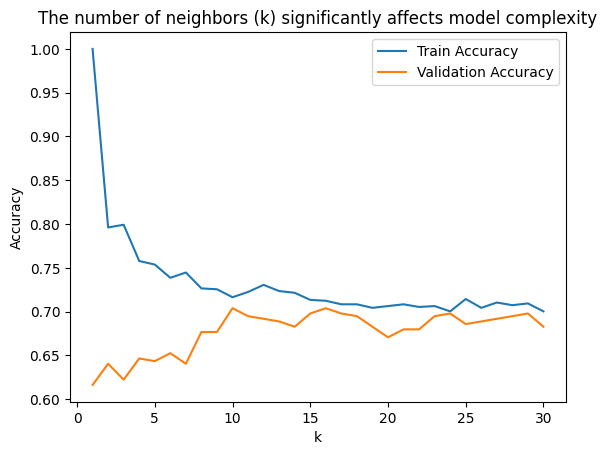

In [20]:
import matplotlib.pyplot as plt
train_scores = []
Validation_scores = []
k_values = range(1, 31)
for k in k_values:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train) #Train the model by training set
# Evaluate on validation
    train_scores.append(knn_model.score(X_train, y_train))
    Validation_scores.append(knn_model.score(X_val, y_val))

plt.plot(k_values, train_scores, label="Train Accuracy")
plt.plot(k_values,Validation_scores, label="Validation Accuracy")
plt.title("The number of neighbors (k) significantly affects model complexity")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### For **small k** values, the model **overfits**, achieving perfect or near-perfect training accuracy but significantly lower validation performance. As **k increases**, training and validation performance converge, indicating **improved generalization**.
### Moderate k values provide the **best balance** between bias and variance.


---



# **B- Tune Hyperparameter** :  GridSearchCV for kNN (Tune **n_neighbors** and **weights**)

In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 31)),
    'kneighborsclassifier__weights': ['uniform', 'distance']
}
# Use GridSearchCV to find the best parameter 'k' using the training+validation data
grid_knn = GridSearchCV(knn_model, param_grid, cv=5, scoring='f1', n_jobs=-1) # Use F1 score because of the slight class imbalance

# Fit the grid search to the combined training/validation data : Cross-validation = built-in validation.
grid_knn.fit(X_train_val, y_train_val)

print("Best parameters found:", grid_knn.best_params_)  # The specific combination of hyperparameters that achieved the highest F1 score.
print(f"Best cross-validation F1 score: {grid_knn.best_score_:.2f}")  # The mean cross-validated score (F1) of the best parameter set.

best_knn = grid_knn.best_estimator_

Best parameters found: {'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__weights': 'distance'}
Best cross-validation F1 score: 0.53


### GridSearchCV identified an optimal neighborhood size that improved minority-class F1-score. Final test evaluation shows moderate overall accuracy (~mid-60%) and improved balance between precision and recall compared to the baseline. However, false negatives for the onSchedule class remain a key limitation.

# **2- Logistic Regression Model**

In [22]:
from sklearn.linear_model import LogisticRegression

logReg_model = Pipeline([
    ("prep", full_prep),               #liblinear: supports L1 (Lasso) regularization, which automatically perform feature selection.
    ("LogRegClf", LogisticRegression( solver="liblinear"))  # stable for small/medium data
])

logReg_model


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration',
                                                   'LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'status',
                                                   'gender',
                                                   'Math101Grade'])])),
                ('LogRegClf', LogisticRegression(solver='liblinear'))])

# **A- Evaluate Performance** (before tuning)

In [23]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

logReg_model.fit(X_train, y_train)   #Train the model

y_val_pred = logReg_model.predict(X_val)

print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred):.2f}") # because dataset is 63% vs 37%, accuracy alone is misleading.
print("Validation F1      :", f"{f1_score(y_val, y_val_pred):.2f}") # F1 = harmonic mean of precision and recall.
print("\nConfusion matrix:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['0-not onSchedule', '1-onSchedule']))


Validation Accuracy: 0.70
Validation F1      : 0.57

Confusion matrix:
 [[167  41]
 [ 57  66]]
                  precision    recall  f1-score   support

0-not onSchedule       0.75      0.80      0.77       208
    1-onSchedule       0.62      0.54      0.57       123

        accuracy                           0.70       331
       macro avg       0.68      0.67      0.67       331
    weighted avg       0.70      0.70      0.70       331



## **Model Performance Report** (before tuning)
###F1-score for class 1 (onSchedule) is the primary metric, Because classes are imbalanced.
### recall for class 1 is low -> The **model tends to favor the majority class**(0).
### The model currently shows a **bias** toward the **majority class** ('not onSchedule'). Because the dataset is imbalanced, the model has learned the characteristics of class 0 more effectively than class 1, leading to a **high rate of False Negatives** for the 'onSchedule' category
###To **fix** this "Recall" **Problem**,  I add **class_weight='balanced'** inside LogisticRegression parameters (in GridSearch) -> This will tell the model to pay **more attention** to the **minority class**.

# **B- Hyperparameter tuning** (optimization) using GridSearchCV

In [24]:
logReg_model = Pipeline([
    ("prep", full_prep),
    ("LogRegClf", LogisticRegression( max_iter=2000, solver="liblinear")) #2000:Maximum number of iterations allowed for convergence
])
param_grid = {
    "LogRegClf__C": np.logspace(-3, 3, 13),       # 0.001 ... 1000  controls model complexity
    "LogRegClf__penalty": ["l1", "l2"],           # Type of regularization
    "LogRegClf__class_weight": [None, "balanced"] # adjusts the importance of minority-class errors
}

cv = StratifiedKFold(n_splits=5, shuffle=True) # preserve class proportions across folds

grid_logReg = GridSearchCV(
    logReg_model, param_grid=param_grid, scoring="f1", cv=cv, n_jobs=-1)

grid_logReg.fit(X_train_val, y_train_val)

print("Best params found:", grid_logReg.best_params_)
print(f"Best cross-validation F1 score:: {grid_logReg.best_score_:.2f}")

best_logReg = grid_logReg.best_estimator_


Best params found: {'LogRegClf__C': np.float64(0.001), 'LogRegClf__class_weight': 'balanced', 'LogRegClf__penalty': 'l2'}
Best cross-validation F1 score:: 0.61


## performance report

# **Final Comparison** (Test Set)

In [ ]:
best_knn.fit(X_train_val, y_train_val)
best_logReg.fit(X_train_val, y_train_val)
best_svm.fit(X_train_val, y_train_val)

In [1]:
#Final Evaluation on Test Set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred = best_logReg.predict(X_test)

y_test_pred = best_knn.predict(X_test)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(grid_knn, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix: Predicted vs Actual')
plt.show()

NameError: name 'grid_knn' is not defined